# Load data 

#### First, we import some libraries

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin

# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

### Import data

In [2]:
data_dir = "../data/"

# the name of the systems we are testing
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

# final results
data = dict()

inputs_name = dict()
inputs_count = dict()
inputs_perf = dict()
inputs_feat = dict()
inputs_categ = dict()
inputs_prop = dict()
inputs_num = dict()


# name of the performance properties
inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["imagemagick"] = ["size", "time"]
inputs_perf["lingeling"] = ["conflicts", "cps", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]

# name of features for each system
inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["imagemagick"] = ["memory_r", "posterize_r", "gaussian-blur", "thread", "quality"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]

# just to isolate the options that have categorial values
# because it is more difficult to handle for ML algorithms
inputs_categ["gcc"] = ["optim"]
inputs_categ["imagemagick"] = []
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock', 'b_adapt', 'b_pyramid', 
                        'open_gop', 'rc_lookahead', 'scenecut', 'weightb']
inputs_categ["xz"] = ['memory', 'format']

for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs_prop[ns] = pd.read_csv(data_path+'/others/properties.csv').set_index('id')
    
    inputs = [str(name)+'.csv' for name in inputs_prop[ns]['name']]

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    inputs_num[ns] = np.setdiff1d(inputs_feat[ns], inputs_categ[ns])
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        df = pd.read_csv(loc)
        if inputs_categ[ns] != []:
            data[ns, i] = df[inputs_num[ns]].join(pd.get_dummies(df[inputs_categ[ns]])).join(df[inputs_perf[ns]])
        else:
            data[ns, i] = df[inputs_num[ns]].join(df[inputs_perf[ns]])

### Example of a dataframe

> **Usage** :  ```data["name_of_my_sotware_system", id_of_my_input]``` returns the dataframe of measurements for this software system on this input

In [3]:
# eg for x264 and the first input
data["x264", 0]

,8x8dct,aq-mode,bframes,cabac,chroma_qp_offset,fast_pskip,mbtree,me_range,mixed_ref,qpmax,...,scenecut_0,scenecut_40,scenecut_None,weightb_1,weightb_None,size,kbs,fps,etime,cpu
0,0,0,0,0,0,1,0,16,0,69,...,1,0,0,0,1,403085,161.07,375.22,2.14,434
1,1,1,8,1,0,1,1,16,1,69,...,1,0,0,1,0,234157,93.57,217.07,3.40,734
2,1,0,8,1,0,1,1,16,1,69,...,1,0,0,1,0,159836,63.87,293.42,2.71,739
3,1,0,8,1,0,1,1,16,1,69,...,1,0,0,1,0,163586,65.37,276.79,2.78,858
4,1,1,3,1,-2,1,0,24,1,69,...,0,1,0,1,0,218392,87.27,287.79,2.74,699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1,1,3,1,0,1,1,16,1,69,...,0,1,0,1,0,183183,73.20,254.20,3.01,716
197,1,1,3,1,0,1,1,24,0,69,...,0,1,0,1,0,195730,78.21,269.38,2.88,644
198,1,1,3,1,-2,0,1,16,1,69,...,0,1,0,1,0,178146,71.19,263.64,2.92,927
199,1,1,3,0,-2,1,0,16,1,69,...,0,1,0,1,0,234018,93.51,267.21,2.89,685


### Non parametric estimation

In [4]:
class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.
    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.
    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.
    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.
    See also
    --------
    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values
        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X):
        """Predict target values for X.
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X, metric=self.kernel, gamma=self.gamma)
        return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()
            return gamma_values[np.nanargmin(mse)]

### First input video (blue)

In [5]:
inputs_name["x264"][15]

'Animation_1080P-5083.csv'

### Print video 1

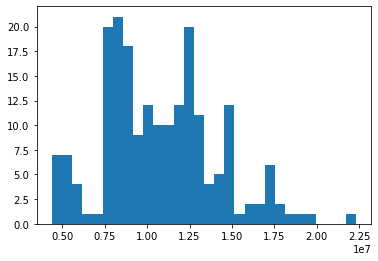

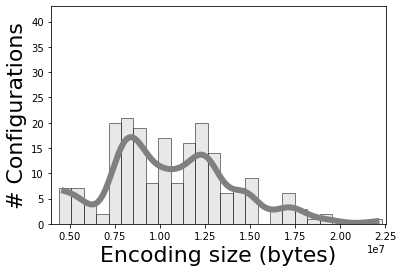

In [29]:
df = data["x264", 15]

k1 = KernelRegression(kernel="rbf")
h = plt.hist(df["size"], bins = 30)
plt.show()

df_estim = pd.DataFrame({'x' : [k for k in h[0]], 
                    'val' : [(h[1][k]+h[1][k+1])/(2*1e6) for k in range(len(h[0]))]})



#start the plot
plt.hist(df["size"], alpha=0.5, color='lightgray', edgecolor='black', linewidth=1, bins = 26)

# predict the distribution
k1.fit(np.array(df_estim.val).reshape(-1,1), df_estim.x)
xval = np.linspace(min(df_estim.val), max(df_estim.val), 500)
plt.plot([k*1e6 for k in xval], k1.predict(np.array(xval).reshape(-1, 1)), 
         linewidth=6, color = 'gray')

# add the rest 
plt.ylabel("# Configurations", size = 22)
plt.xlabel("Encoding size (bytes)", size = 22)
plt.xlim(min(df["size"])*0.9, max(df["size"])*1.01)
plt.ylim(0,43)
#plt.xticks([])
#plt.yticks([])
plt.savefig("../results/intro15.png", dpi = 300, bbox_inches='tight')
plt.show()

### Second input video (orange)

In [7]:
inputs_name["x264"][18]

'Animation_1080P-646f.csv'

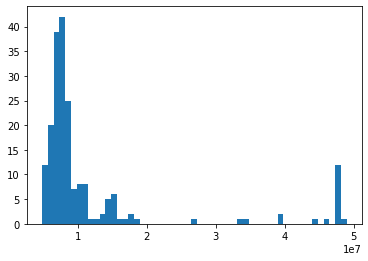

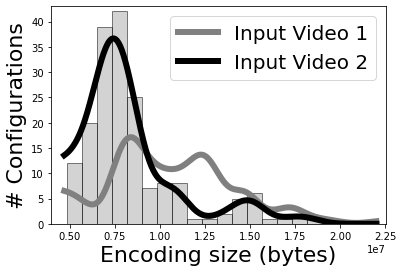

In [31]:
df2 = data["x264", 18]

k2 = KernelRegression(kernel="rbf")
h = plt.hist(df2["size"], bins = 53)
plt.show()

df2_estim = pd.DataFrame({'x' : [k for k in h[0]], 
                    'val' : [(h[1][k]+h[1][k+1])/(2*1e6) for k in range(len(h[0]))]})
k2.fit(np.array(df2_estim.val).reshape(-1,1), df2_estim.x)

#start the plot
plt.hist(df2["size"], alpha=0.5, edgecolor='black', linewidth=1, color="darkgray", bins = 53)

# predict the distribution
plt.plot([k*1e6 for k in xval], k1.predict(np.array(xval).reshape(-1, 1)), 
         linewidth=6, color = 'gray', label = 'Input Video 1')
plt.plot([k*1e6 for k in xval], k2.predict(np.array(xval).reshape(-1, 1)), 
         linewidth=6, color = 'black', label = 'Input Video 2')

# add the rest 
plt.ylabel("# Configurations", size = 22)
plt.xlabel("Encoding size (bytes)", size = 22)
plt.xlim(min(df["size"])*0.9, max(df["size"])*1.01)
plt.ylim(0,43)

leg = plt.legend(fontsize = 20)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(6.0)
    
#plt.xticks([])
#plt.yticks([])
plt.savefig("../results/intro18.png", dpi = 300, bbox_inches='tight')
plt.show()